# From Cliché to Canon: Patterns, Tradition, and Innovation in 2000 Titles of Russian Novels in Comparative Perspective (1763-1917)

In [ ]:
import pickle
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from adjustText import adjust_text
from tqdm import tqdm

from scipy import stats
from scipy.signal import savgol_filter
from scipy.spatial.distance import cosine

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

from transformers import AutoTokenizer, AutoModel
import torch

In [68]:
np.random.seed(42)

# load and prepare data
data = pd.read_csv("novels_titles_raw.csv")
print(f"Original dataset: {len(data)} rows, {len(data.columns)} columns")

required_columns = [
    'author', 'gender', 'pseudonym', 'title', 'subtitle', 'year_begin',
    'source', 'sep_edition', 'city', 'genre', 'characters', 'narration',
    'main_genre', 'general_genre', 'POS_title', 'title_length', 'canon_status'
]

data = data[required_columns].copy()
data = data.sort_values('year_begin').reset_index(drop=True)

# save processed data
Path('data').mkdir(exist_ok=True)
data.to_csv('data/novels_titles_processed.csv', index=False, encoding='utf-8')

print(f"Processed dataset: {len(data)} rows, {len(data.columns)} columns")

data.head()

Original dataset: 2233 rows, 20 columns
Processed dataset: 2233 rows, 17 columns


,author,gender,pseudonym,title,subtitle,year_begin,source,sep_edition,city,genre,characters,narration,main_genre,general_genre,POS_title,title_length,canon_status
0,"Эмин, Федор Александрович",мужской,0,"Награждённая постоянность, или Приключения Лиз...",Сочинения Федора Эмина,1763,Отд. изд.,1,Санкт-Петербург,любовный,дворяне,3 лицо,любовный,любовный,PRTF NOUN CONJ NOUN NOUN CONJ NOUN,7,0
1,"Эмин, Федор Александрович",мужской,0,"Непостоянная фортуна, или Похождения Мирамонда",NaN,1763,Отд. изд.,1,Санкт-Петербург,авантюрный,дворяне,3 лицо,авантюрный,приключенческий,ADJF NOUN CONJ NOUN NOUN,5,0
2,"Эмин, Федор Александрович",мужской,0,"Приключения Фемистокла и разные политические, ...",NaN,1763,Отд. изд.,1,Санкт-Петербург,исторический,легендарные исторические фигуры,3 лицо,исторический,исторический,NOUN VERB CONJ ADJF ADJF ADJF ADJF ADJF CONJ N...,22,0
3,"Чулков, Михаил Дмитриевич",мужской,0,"Пересмешник, или Славенские сказки",NaN,1766,Отд. изд.,1,Санкт-Петербург,NaN,духовенство,3 лицо,NaN,NaN,NOUN CONJ ADJF NOUN,4,0
4,"Эмин, Федор Александрович",мужской,0,Письма Эрнеста и Доравры,NaN,1766,Отд. изд.,1,Санкт-Петербург,"философский, любовный",дворяне,в письмах,философский,философский,NOUN NOUN CONJ NOUN,4,0


## Data Filtration

In [69]:
data = pd.read_csv('data/novels_titles_processed.csv')

# filter by year
data = data[data['year_begin'] != '19??']
data['year_begin'] = data['year_begin'].astype('int64')
data = data[data['year_begin'] <= 1917]

# normalize categorical variables
data['gender'] = data['gender'].replace({
    'na': 'аноним',
    'мужской, женский': 'женский и мужской'
})

data['sep_edition'] = data['sep_edition'].apply(
    lambda x: 'отдельное издание' if x == 1 else 'периодика/сборник'
)

data['city'] = data['city'].str.split(';').str[0]
data['city'] = data['city'].fillna('не определен (периодика)')
data['city'] = data['city'].replace('Петроград', 'Санкт-Петербург')

data['city_group'] = data['city'].apply(
    lambda x: 'Санкт-Петербург' if x == 'Санкт-Петербург' else
              'Москва' if x == 'Москва' else
              'не определен (периодика)' if x == 'не определен (периодика)' else
              'Европейские города' if x in ['Берлин', 'Мюнхен', 'Женева', 'Лондон', 'Рига'] else
              'Другие города Российской Империи'
)

data['narration'] = data['narration'].replace({
    '3 лицо (пролог - 1 лицо)': '1 и 3 лицо',
    '3 лицо; 1 лицо': '1 и 3 лицо',
    '3 лицо + 1л (дневник)': '1 и 3 лицо',
    'в письмах, 3 лицо': '3 лицо',
    '1 лицо + 3 лицо': '1 и 3 лицо',
    '3 лицо; 1 лицо; в письмах': '1 и 3 лицо',
    'н/д': pd.NA
})

data = data.sort_values('year_begin').reset_index(drop=True)

print(f"Dataset: {len(data)} novels, {data['year_begin'].min()}-{data['year_begin'].max()}")
print(f"Canonical novels: {data['canon_status'].sum()}")

Dataset: 2029 novels, 1763-1917
Canonical novels: 79


## Exploratory Data Analysis

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author         2029 non-null   object
 1   gender         2029 non-null   object
 2   pseudonym      2029 non-null   int64 
 3   title          2029 non-null   object
 4   subtitle       1888 non-null   object
 5   year_begin     2029 non-null   int64 
 6   source         2029 non-null   object
 7   sep_edition    2029 non-null   object
 8   city           2029 non-null   object
 9   genre          1686 non-null   object
 10  characters     1222 non-null   object
 11  narration      1407 non-null   object
 12  main_genre     1657 non-null   object
 13  general_genre  1657 non-null   object
 14  POS_title      2029 non-null   object
 15  title_length   2029 non-null   int64 
 16  canon_status   2029 non-null   int64 
 17  city_group     2029 non-null   object
dtypes: int64(4), object(14)
memo

In [71]:
# create figures directory
Path('figures').mkdir(exist_ok=True)

### year_begin

The distribution of novels by year is uneven, reflecting the dynamics of the novel market in the Russian Empire:

- **1770s-1820s**: Emergence of the genre with the first rare novels, mostly translations
- **1830s**: First full-fledged Russian novels (Bulgarin); 1831 - "Eugene Onegin", 1840 - "A Hero of Our Time", 1842 - "Dead Souls"
- **1850s-70s**: Novels by Turgenev, Goncharov, Dostoevsky, and Tolstoy appear
- **1880s-1917**: The novel becomes the dominant genre of Russian literature with high publication volumes

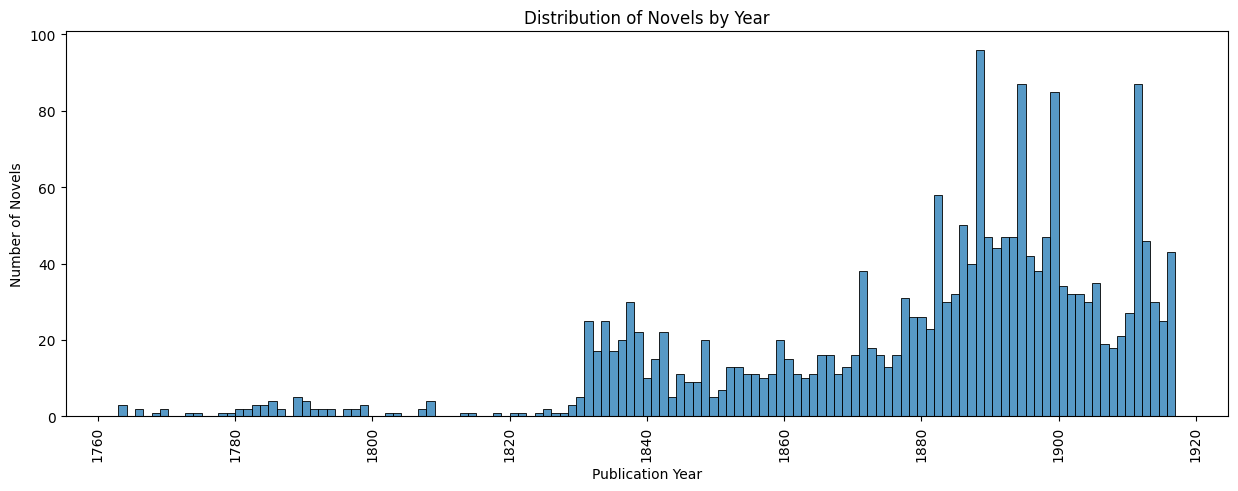

In [72]:
plt.figure(figsize=(15, 5))
sns.histplot(x=data['year_begin'], bins=data['year_begin'].nunique(), kde=False)
plt.xlabel('Publication Year')
plt.ylabel('Number of Novels')
plt.title('Distribution of Novels by Year')
plt.xticks(rotation=90)
plt.savefig('figures/distribution_by_year.png', dpi=150, bbox_inches='tight')
plt.show()

### general_genre

The dataset contains 3 genre-related columns with different levels of generalization:

- `genre`: 495 unique values (raw genre indication from bibliographic references)
- `main_genre`: 47 unique values (aggregated categories)
- `general_genre`: 20 unique values (high-level categories used in this analysis)

Historical and social novels dominate the corpus (~33% each), while other genres range from 1% to 7%.

In [73]:
print('Number of unique values in "genre" column:', data['genre'].nunique())
print('Number of unique values in "main_genre" column:', data['main_genre'].nunique())
print('Number of unique values in "general_genre" column:', data['general_genre'].nunique())

print('\nNumber of novels with defined "genre":', data['genre'].notna().sum())
print('Number of novels with defined "main_genre":', data['main_genre'].notna().sum())
print('Number of novels with defined "general_genre":', data['general_genre'].notna().sum())


Number of unique values in "genre" column: 495
Number of unique values in "main_genre" column: 47
Number of unique values in "general_genre" column: 20

Number of novels with defined "genre": 1686
Number of novels with defined "main_genre": 1657
Number of novels with defined "general_genre": 1657


In [74]:
genre_distribution = data[data['general_genre'].notna()]['general_genre'].value_counts()
genre_distribution = genre_distribution.to_frame().reset_index()
genre_distribution.columns = ['general_genre', 'count']
genre_distribution['percent'] = (genre_distribution['count'] / genre_distribution['count'].sum()) * 100
genre_distribution = genre_distribution.sort_values(by='percent', ascending=False)
print(genre_distribution)

      general_genre  count    percent
0        социальный    548  33.071817
1      исторический    547  33.011467
2      криминальный    117   7.060954
3          любовный     87   5.250453
4   приключенческий     86   5.190103
5          семейный     45   2.715751
6    юмористический     34   2.051901
7          светский     33   1.991551
8    фантастический     32   1.931201
9   психологический     30   1.810501
10       воспитания     21   1.267351
11     описательный     19   1.146651
12      философский     16   0.965600
13   биографический     15   0.905250
14      утопический     12   0.724200
15          женский      5   0.301750
16     эпистолярный      4   0.241400
17    символистский      4   0.241400
18          детский      1   0.060350
19  ориенталистский      1   0.060350


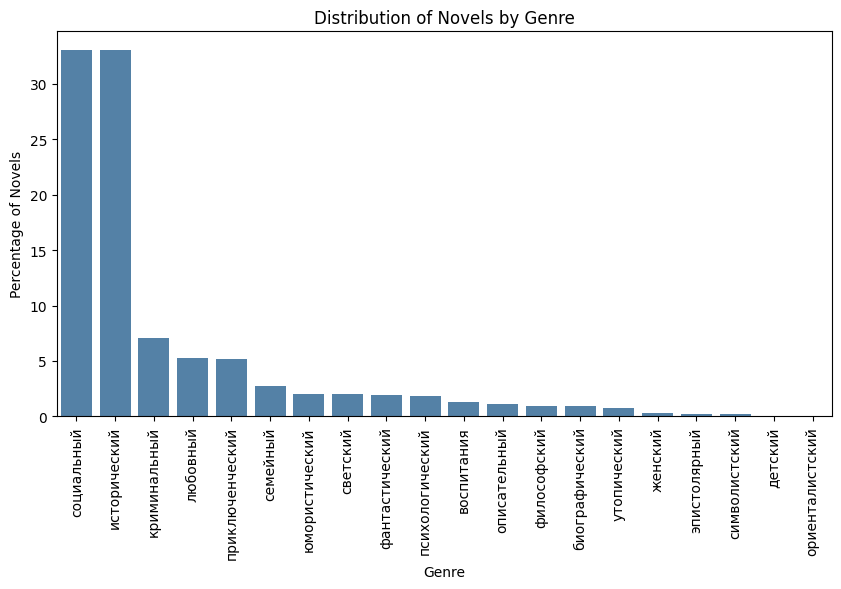

In [75]:
plt.figure(figsize=(10, 5))
sns.barplot(x='general_genre', y='percent', data=genre_distribution, color='steelblue')
plt.xlabel('Genre')
plt.ylabel('Percentage of Novels')
plt.title('Distribution of Novels by Genre')
plt.xticks(rotation=90)
plt.savefig('figures/distribution_by_genre.png', dpi=150, bbox_inches='tight')
plt.show()

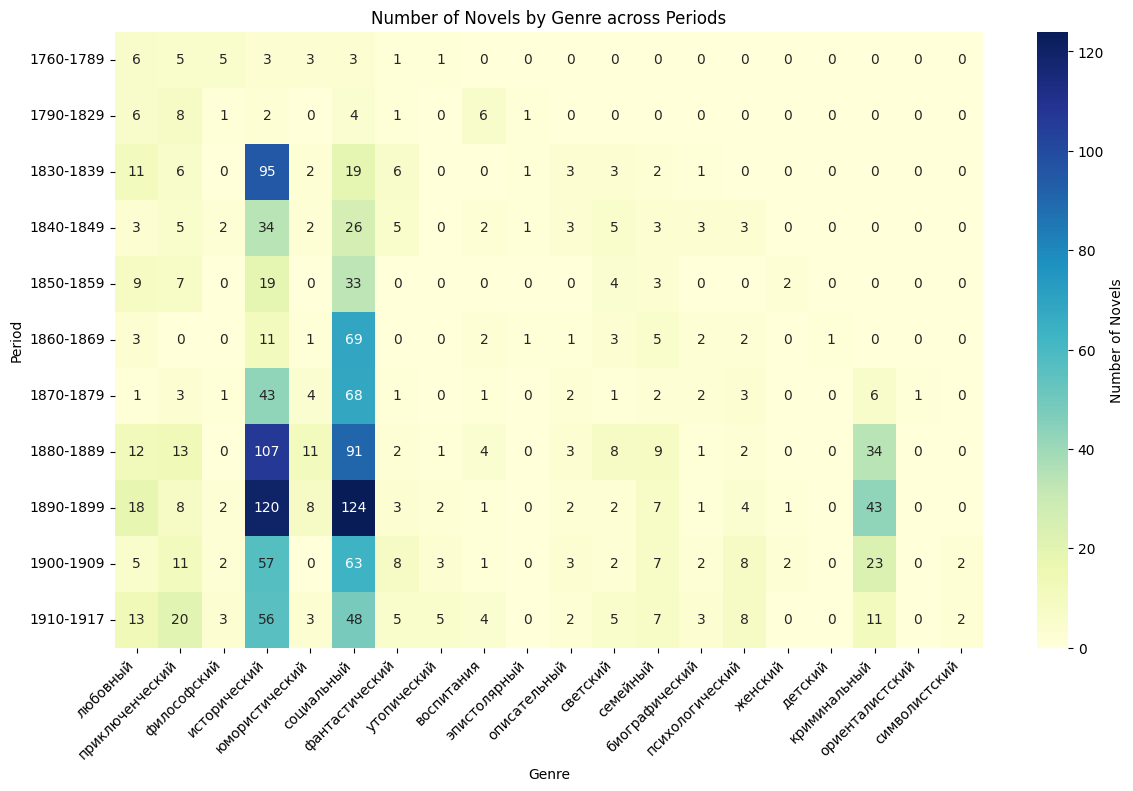

In [76]:
# genre distribution by period (heatmap)
def plot_genre_by_period(data, periods):
    genre_counts = {}
    for period in periods:
        parts = period.split('-')
        start, end = int(parts[0]), int(parts[1])
        period_data = data[(data['year_begin'] >= start) & (data['year_begin'] <= end)]
        genre_counts[period] = period_data['general_genre'].value_counts().to_dict()
    
    df = pd.DataFrame(genre_counts).T.fillna(0)
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Number of Novels'})
    plt.title('Number of Novels by Genre across Periods')
    plt.xlabel('Genre')
    plt.ylabel('Period')
    plt.xticks(rotation=45, ha='right')
    plt.savefig('figures/genre_by_period_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

periods = ['1760-1789', '1790-1829', '1830-1839', '1840-1849', '1850-1859', 
           '1860-1869', '1870-1879', '1880-1889', '1890-1899', '1900-1909', '1910-1917']
plot_genre_by_period(data, periods)

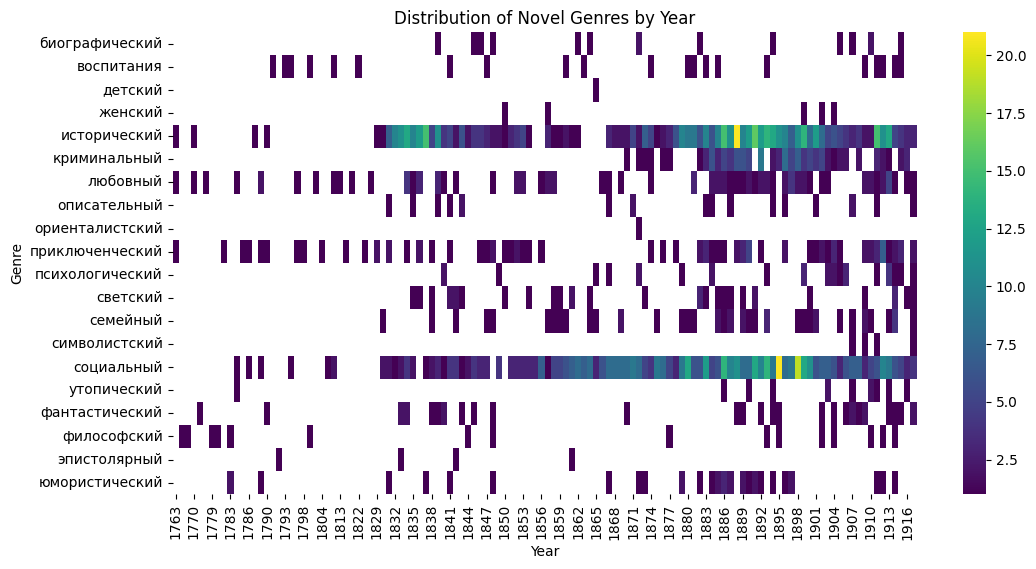

In [77]:
genre_by_year = data.groupby(['year_begin', 'general_genre']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.heatmap(genre_by_year.pivot(index='general_genre', columns='year_begin', values='count'), cmap='viridis')
plt.xlabel('Year')
plt.ylabel('Genre')
plt.title('Distribution of Novel Genres by Year')
plt.savefig('figures/genre_by_year_heatmap.png', dpi=150, bbox_inches='tight')
plt.xticks(rotation=90)
plt.show()

### sep_edition


sep_edition
отдельное издание    1203
периодика/сборник     826
Name: count, dtype: int64


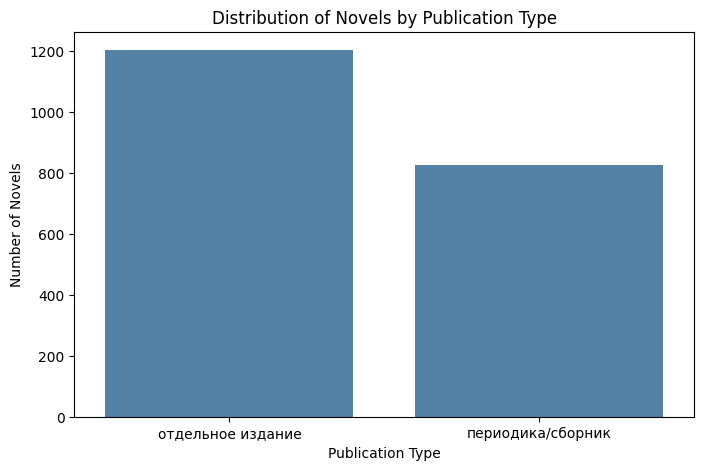

In [78]:
print(data['sep_edition'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x=data['sep_edition'], color='steelblue')
plt.xlabel('Publication Type')
plt.ylabel('Number of Novels')
plt.title('Distribution of Novels by Publication Type')
plt.savefig('figures/distribution_by_publication_type.png', dpi=150, bbox_inches='tight')
plt.show()

### gender

gender
мужской              1703
женский               307
аноним                 15
женский и мужской       4
Name: count, dtype: int64


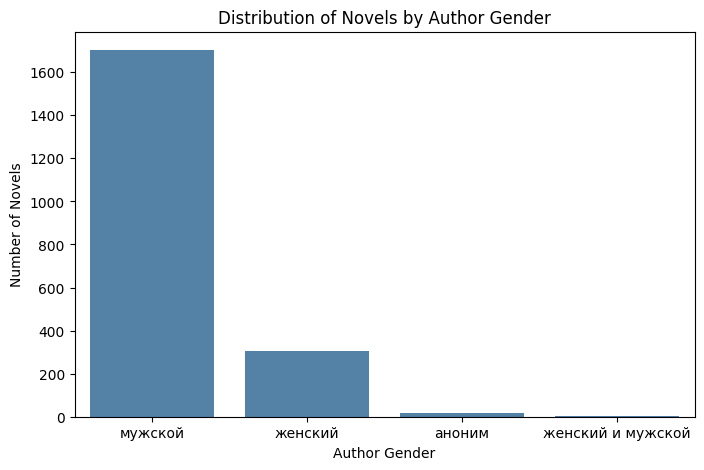

In [79]:
print(data['gender'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x=data['gender'], color='steelblue')
plt.xlabel('Author Gender')
plt.ylabel('Number of Novels')
plt.title('Distribution of Novels by Author Gender')
plt.savefig('figures/distribution_by_gender.png', dpi=150, bbox_inches='tight')
plt.show()

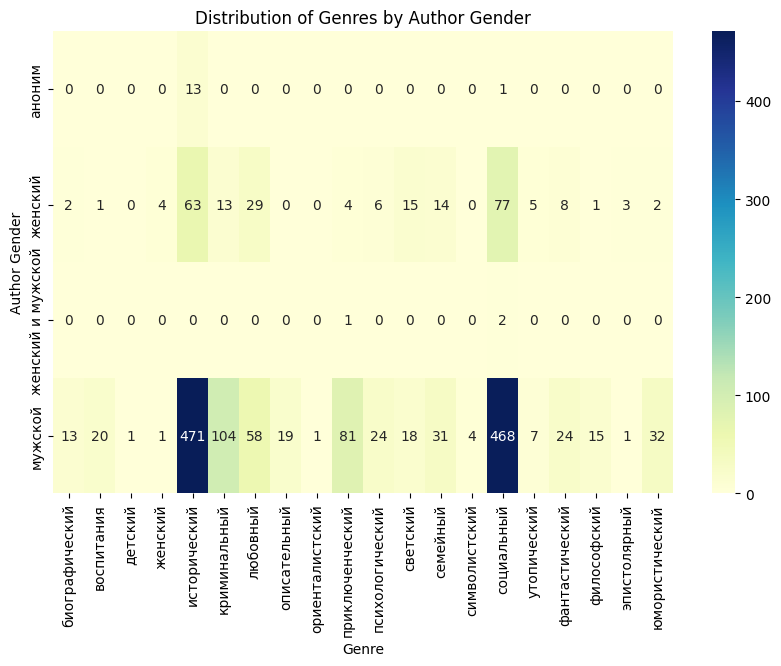

In [80]:
# genre by gender heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(data['gender'], data['general_genre']), 
            annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Genre')
plt.ylabel('Author Gender')
plt.title('Distribution of Genres by Author Gender')
plt.savefig('figures/genre_by_gender_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### city

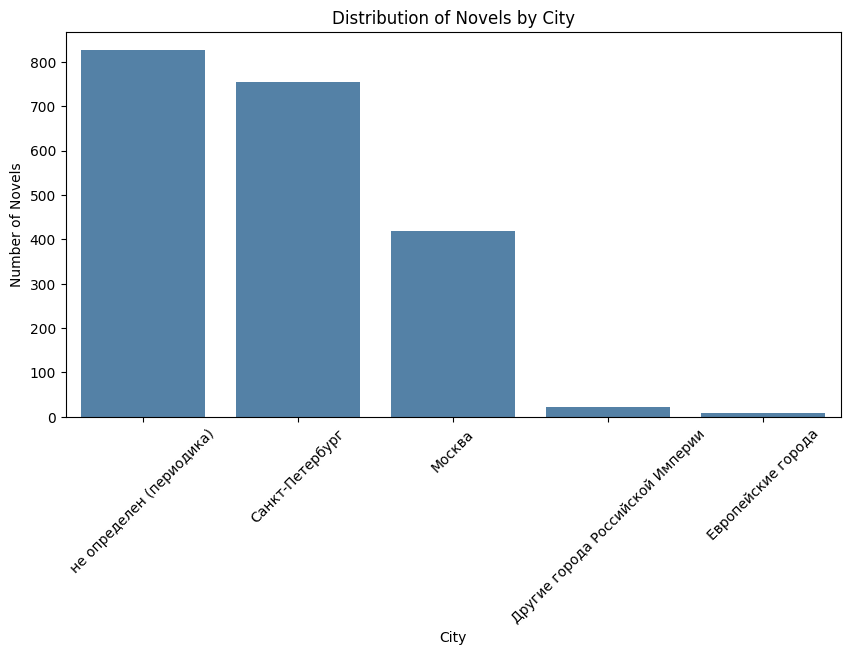

In [81]:
plt.figure(figsize=(10, 5))
sns.countplot(x=data['city_group'], order=data['city_group'].value_counts().index, color='steelblue')
plt.xlabel('City')
plt.ylabel('Number of Novels')
plt.title('Distribution of Novels by City')
plt.xticks(rotation=45)
plt.savefig('figures/distribution_by_city.png', dpi=150, bbox_inches='tight')
plt.show()

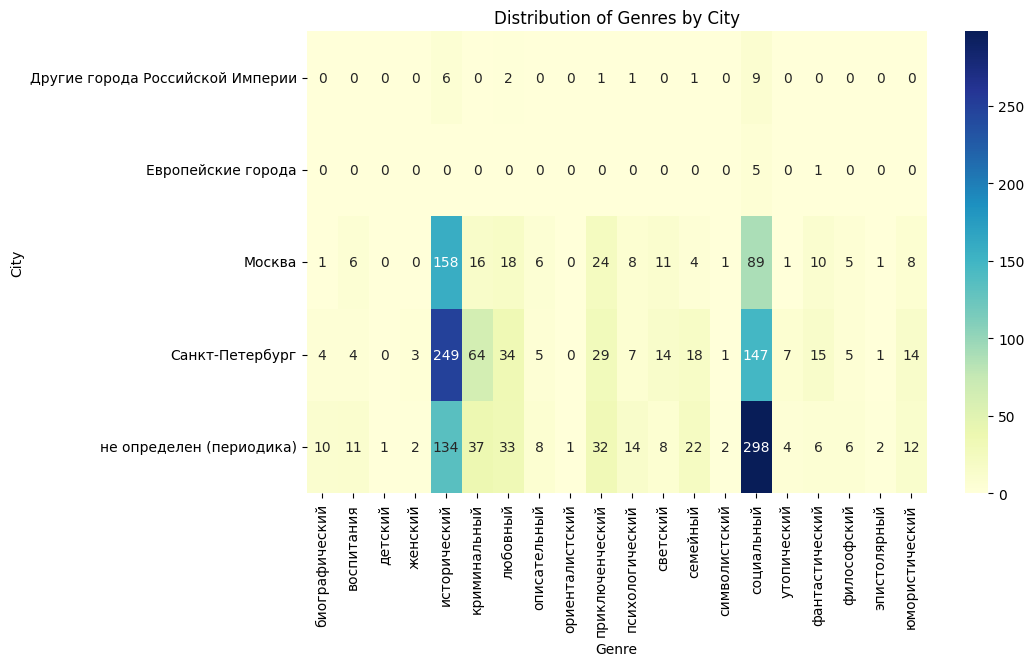

In [82]:
# genre by city heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(data['city_group'], data['general_genre']), 
            annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Genre')
plt.ylabel('City')
plt.title('Distribution of Genres by City')
plt.savefig('figures/genre_by_city_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### POS_title

The dataset contains 364 unique POS (part-of-speech) title constructions. Over half (51%) of titles belong to just three types:

- **NOUN** (18.8%): single noun titles, e.g., "Silhouette" (1851), "The Dreamer" (1858)
- **ADJF NOUN** (16.85%): adjective + noun, e.g., "The Captain's Daughter" (1836), "An Ordinary Story" (1847)
- **NOUN NOUN** (13.45%): noun + noun, e.g., "Princess Menshikova" (1833), "The Actress's Son" (1838)

In [83]:
# top 20 POS constructions
pos_counts = data['POS_title'].value_counts()

pos_table = []
for pos, count in pos_counts.head(20).items():
    example = data[data['POS_title'] == pos]['title'].iloc[0]
    pos_table.append({
        'Construction': pos,
        'Example': example,
        'Count': count,
        'Percentage': f'{count / len(data) * 100:.2f}%'
    })

pos_df = pd.DataFrame(pos_table)
print(pos_df.to_string(index=False))

       Construction                          Example  Count Percentage
               NOUN                         Небылица    381     18.78%
          ADJF NOUN            Добродетельная Розана    342     16.86%
          NOUN NOUN                      Игра судьбы    273     13.45%
          PREP NOUN                       У пристани     83      4.09%
     PREP NOUN NOUN                     В чужом поле     66      3.25%
     NOUN CONJ NOUN                  Кадм и Гармония     59      2.91%
     PREP ADJF NOUN                     В своем краю     53      2.61%
     NOUN ADJF NOUN         Картины дружеских связей     43      2.12%
     NOUN NOUN NOUN Похождение некотораго россиянина     42      2.07%
          NOUN ADJF               Ольга Милославская     35      1.72%
     NOUN PREP NOUN               Поездка в Германию     32      1.58%
          NUMR NOUN                       Три сердца     28      1.38%
               ADJF                        Проклятый     24      1.18%
      

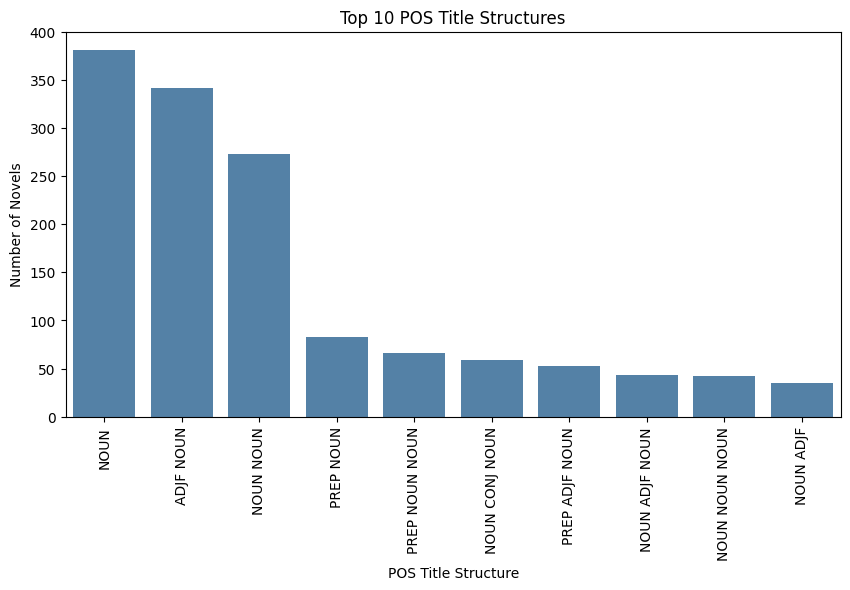

In [84]:
plt.figure(figsize=(10, 5))
sns.barplot(x=pos_counts.index[:10], y=pos_counts.values[:10], color='steelblue')
plt.xlabel('POS Title Structure')
plt.ylabel('Number of Novels')
plt.title('Top 10 POS Title Structures')
plt.xticks(rotation=90)
plt.savefig('figures/top_pos_structures.png', dpi=150, bbox_inches='tight')
plt.show()

In [85]:
# POS constructions before/after 1830
construction_counts = Counter(data['POS_title'])
n_before = len(data[data['year_begin'] < 1830])
n_after = len(data[data['year_begin'] >= 1830])

result = []
for construction, count in construction_counts.most_common(50):
    example = data[data['POS_title'] == construction]['title'].iloc[0]
    pct_before = len(data[(data['POS_title'] == construction) & (data['year_begin'] < 1830)]) / n_before * 100
    pct_after = len(data[(data['POS_title'] == construction) & (data['year_begin'] >= 1830)]) / n_after * 100
    result.append({
        'Construction': construction,
        'Example': example,
        'Count': count,
        'Before 1830 (%)': f'{pct_before:.2f}',
        'After 1830 (%)': f'{pct_after:.2f}'
    })

pd.DataFrame(result)

,Construction,Example,Count,Before 1830 (%),After 1830 (%)
0,NOUN,Небылица,381,7.04,19.20
1,ADJF NOUN,Добродетельная Розана,342,7.04,17.21
2,NOUN NOUN,Игра судьбы,273,5.63,13.74
3,PREP NOUN,У пристани,83,0.00,4.24
4,PREP NOUN NOUN,В чужом поле,66,0.00,3.37
5,NOUN CONJ NOUN,Кадм и Гармония,59,5.63,2.81
6,PREP ADJF NOUN,В своем краю,53,0.00,2.71
7,NOUN ADJF NOUN,Картины дружеских связей,43,0.00,2.20
8,NOUN NOUN NOUN,Похождение некотораго россиянина,42,2.82,2.04
9,NOUN ADJF,Ольга Милославская,35,0.00,1.79


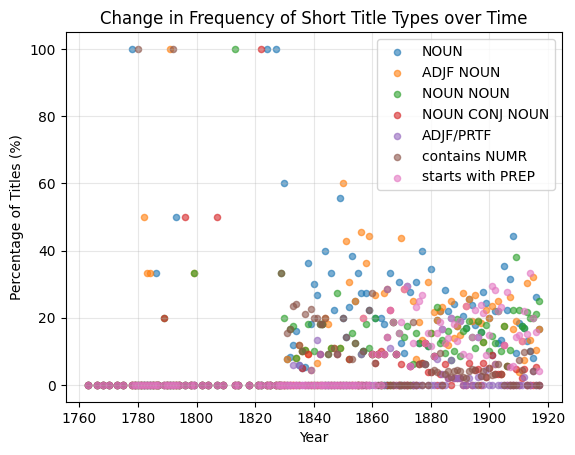

In [86]:
# short title constructions by year (scatter)
df = data
constructions = {
    'NOUN': [],
    'ADJF NOUN': [],
    'NOUN NOUN': [],
    'NOUN CONJ NOUN': [],
    'ADJF/PRTF': [],
    'contains NUMR': [],
    'starts with PREP': []
}

for year in df['year_begin'].unique():
    year_data = df[df['year_begin'] == year]
    total = len(year_data)
    
    for construction in constructions:
        if construction == 'starts with PREP':
            count = len(year_data[year_data['POS_title'].str.startswith('PREP')])
        elif construction == 'contains NUMR':
            count = len(year_data[year_data['POS_title'].str.contains('NUMR')])
        elif construction == 'ADJF/PRTF':
            count = len(year_data[year_data['POS_title'] == 'ADJF']) + len(year_data[year_data['POS_title'] == 'PRTF'])
        else:
            count = len(year_data[year_data['POS_title'] == construction])
        
        constructions[construction].append((count / total) * 100)

years = sorted(df['year_begin'].unique())
for construction, percentages in constructions.items():
    plt.scatter(years, percentages, label=construction, alpha=0.6, s=20)

plt.xlabel('Year')
plt.ylabel('Percentage of Titles (%)')
plt.title('Change in Frequency of Short Title Types over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/title_types_by_year_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

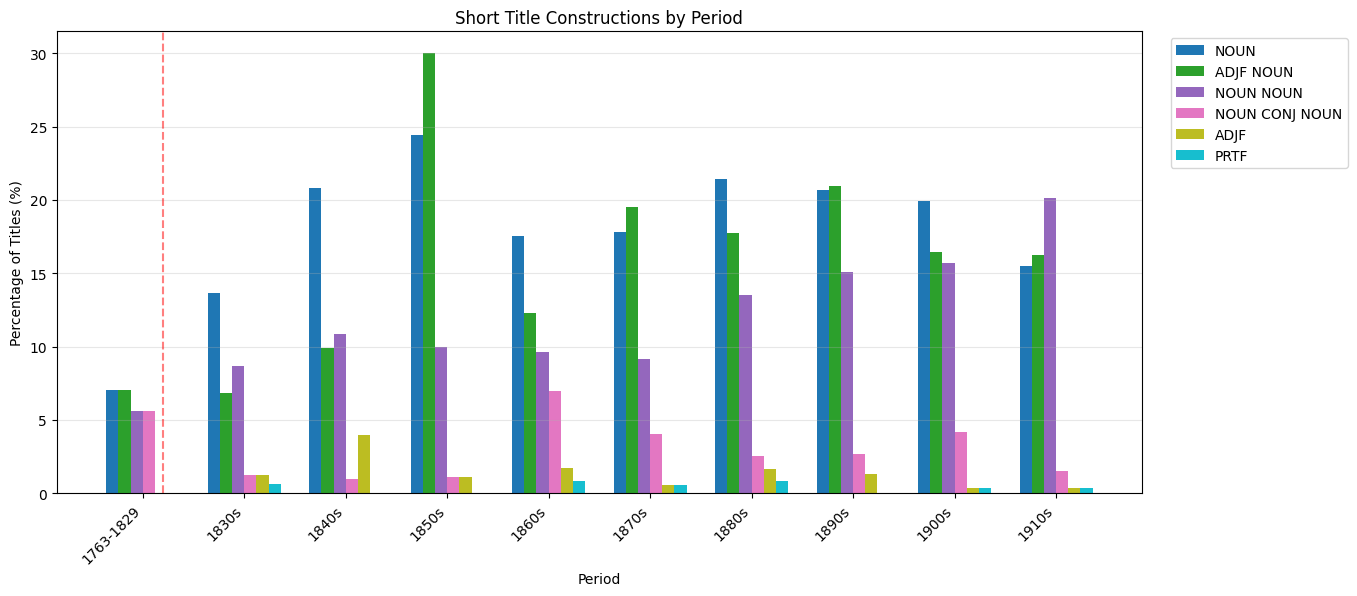

In [87]:
# short title constructions by decade (bar chart)
def get_decade(year):
    return '1763-1829' if year < 1830 else f"{(year // 10) * 10}s"

data['decade'] = data['year_begin'].apply(get_decade)
constructions_bar = ['NOUN', 'ADJF NOUN', 'NOUN NOUN', 'NOUN CONJ NOUN', 'ADJF', 'PRTF']

decades = sorted(data['decade'].unique(), key=lambda x: int(x.split('-')[0]) if '-' in x else int(x[:-1]))
stats_list = []

for decade in decades:
    decade_data = data[data['decade'] == decade]
    total = len(decade_data)
    row = {'decade': decade}
    for c in constructions_bar:
        row[c] = (decade_data['POS_title'] == c).sum() / total * 100
    stats_list.append(row)

stats_df = pd.DataFrame(stats_list)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(stats_df))
width = 0.12
colors = plt.cm.tab10(np.linspace(0, 1, len(constructions_bar)))

for i, c in enumerate(constructions_bar):
    ax.bar(x + i * width, stats_df[c], width, label=c, color=colors[i])

ax.set_xlabel('Period')
ax.set_ylabel('Percentage of Titles (%)')
ax.set_title('Short Title Constructions by Period')
ax.set_xticks(x + width * (len(constructions_bar) - 1) / 2)
ax.set_xticklabels(stats_df['decade'], rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
plt.savefig('figures/title_constructions_by_decade.png', dpi=150, bbox_inches='tight')
plt.show()

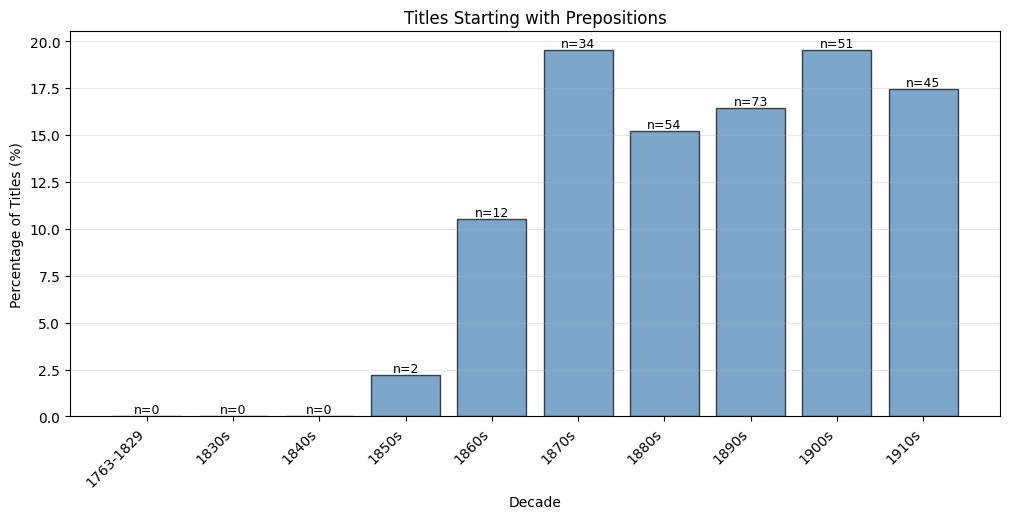

In [88]:
# prepositional titles by decade
data['starts_with_prep'] = data['POS_title'].str.startswith('PREP')

prep_by_decade = data.groupby('decade').agg(
    prep_count=('starts_with_prep', 'sum'),
    total=('starts_with_prep', 'count')
).reset_index()
prep_by_decade['percentage'] = prep_by_decade['prep_count'] / prep_by_decade['total'] * 100

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(prep_by_decade['decade'], prep_by_decade['percentage'], 
              color='steelblue', edgecolor='black', alpha=0.7)

for bar, count in zip(bars, prep_by_decade['prep_count']):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'n={int(count)}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Decade')
ax.set_ylabel('Percentage of Titles (%)')
ax.set_title('Titles Starting with Prepositions')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.savefig('figures/prepositional_titles_by_decade.png', dpi=150, bbox_inches='tight')
plt.show()

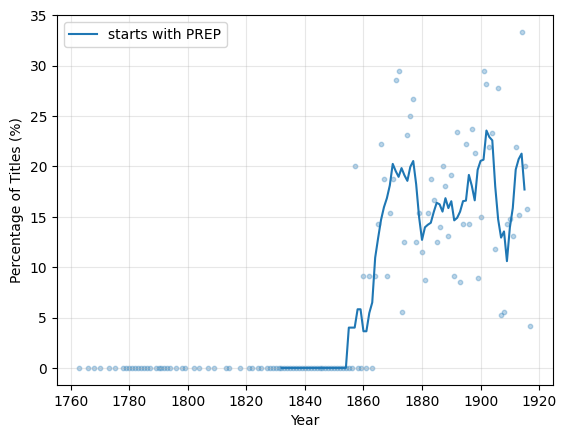

In [89]:
# prepositional titles by year with smoothing
constructions = {'starts with PREP': []}

for year in df['year_begin'].unique():
    year_data = df[df['year_begin'] == year]
    total = len(year_data)
    count = len(year_data[year_data['POS_title'].str.startswith('PREP')])
    constructions['starts with PREP'].append((count / total) * 100)

years = sorted(df['year_begin'].unique())
for construction, percentages in constructions.items():
    start_index = next((i for i, year in enumerate(years) if year >= 1830), 0)
    smoothed_percentages = pd.Series(percentages[start_index:]).rolling(window=5, center=True).mean()
    
    plt.scatter(years, percentages, label=None, alpha=0.3, s=10)
    plt.plot(years[start_index:], smoothed_percentages, label=construction)

plt.xlabel('Year')
plt.ylabel('Percentage of Titles (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/prepositional_titles_by_year_smoothed.png', dpi=150, bbox_inches='tight')
plt.show()

Total prepositional titles: 271


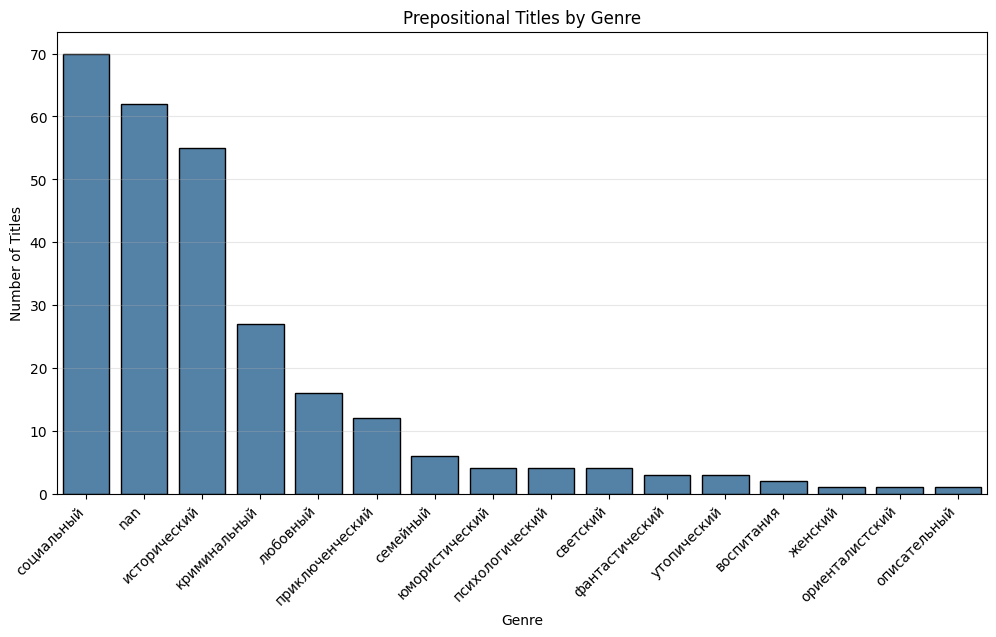

general_genre
социальный         70
NaN                62
исторический       55
криминальный       27
любовный           16
приключенческий    12
семейный            6
юмористический      4
психологический     4
светский            4
фантастический      3
утопический         3
воспитания          2
женский             1
ориенталистский     1
описательный        1
Name: count, dtype: int64

In [90]:
# prepositional titles by genre
prep_titles = data[data['starts_with_prep']]
print(f'Total prepositional titles: {len(prep_titles)}')

genre_stats = prep_titles['general_genre'].value_counts(dropna=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_stats.index.astype(str), y=genre_stats.values, color='steelblue', edgecolor='black')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.title('Prepositional Titles by Genre')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.savefig('figures/prepositional_titles_by_genre.png', dpi=150, bbox_inches='tight')
plt.show()

genre_stats

### title_length

**Title Length Statistics:**
- Minimum: 1 word, Maximum: 22 words
- Median: 2 words, Mean: ~2.7 words
- 75% of titles have ≤3 words

The distribution has a long right tail (non-normal): short titles dominate, but early novels (1760-1820) had titles reaching 22 words.

**Key finding:** Average title length sharply decreases from ~20 words in the 18th century to ~2 words by the 1850s, remaining stable until 1917. This reflects the transition from long annotative titles to short, symbolic ones.

count    2029.000000
mean        2.719566
std         2.037062
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        22.000000
Name: title_length, dtype: float64


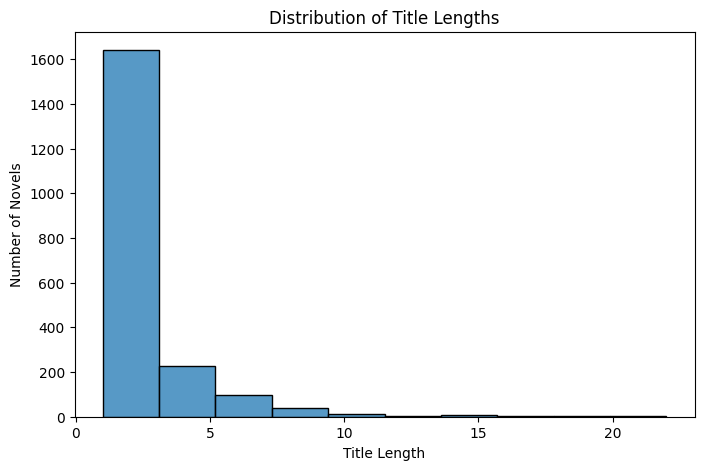

In [91]:
print(data['title_length'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(x=data['title_length'], bins=10, kde=False)
plt.xlabel('Title Length')
plt.ylabel('Number of Novels')
plt.title('Distribution of Title Lengths')
plt.savefig('figures/title_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

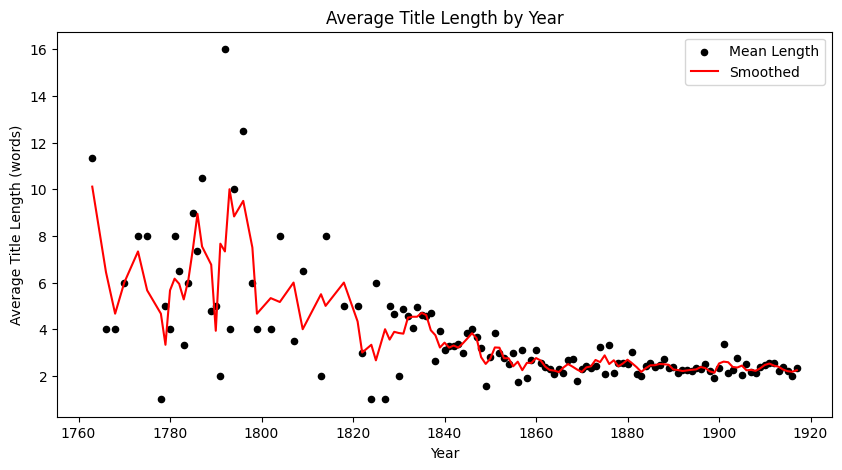

In [92]:
# title length by year
title_length_by_year = data.groupby('year_begin')['title_length'].mean().reset_index()
title_length_by_year['smoothed'] = savgol_filter(title_length_by_year['title_length'], 
                                                  window_length=3, polyorder=1)

plt.figure(figsize=(10, 5))
plt.scatter(title_length_by_year['year_begin'], title_length_by_year['title_length'], 
            color='black', s=20, label='Mean Length')
plt.plot(title_length_by_year['year_begin'], title_length_by_year['smoothed'], 
         color='red', label='Smoothed')
plt.xlabel('Year')
plt.ylabel('Average Title Length (words)')
plt.title('Average Title Length by Year')
plt.legend()
plt.savefig('figures/title_length_by_year.png', dpi=150, bbox_inches='tight')
plt.show()

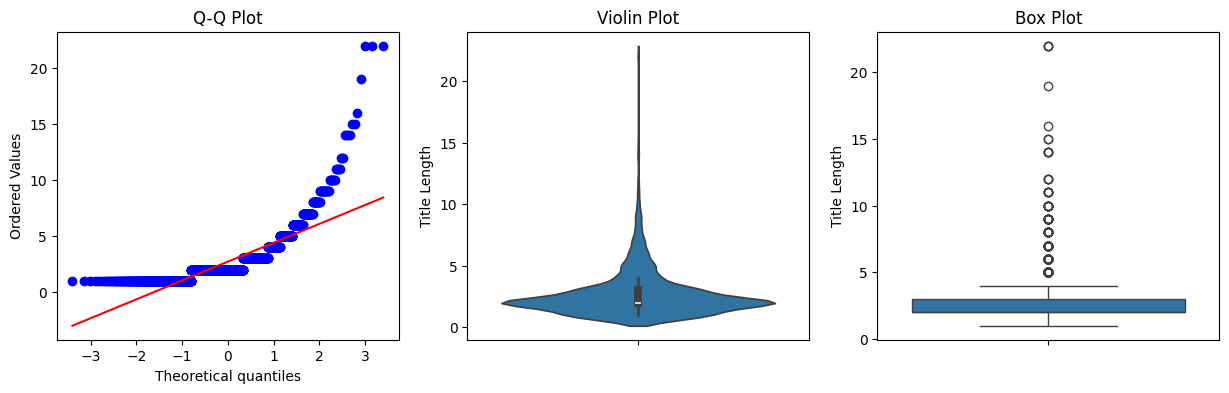

In [93]:
# title length: normality assessment
from scipy import stats

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

stats.probplot(data['title_length'], plot=axes[0])
axes[0].set_title('Q-Q Plot')

sns.violinplot(y=data['title_length'], ax=axes[1])
axes[1].set_ylabel('Title Length')
axes[1].set_title('Violin Plot')

sns.boxplot(y=data['title_length'], ax=axes[2])
axes[2].set_ylabel('Title Length')
axes[2].set_title('Box Plot')

plt.savefig('figures/title_length_normality.png', dpi=150, bbox_inches='tight')
plt.show()

### narration

In [94]:
data['narration'].value_counts()

narration
3 лицо        1204
1 лицо         181
в письмах       17
1 и 3 лицо       5
Name: count, dtype: int64

### canon_status

In [95]:
print(f"Canonical novels: {data['canon_status'].sum()}")

# list canonical novels
for _, row in data[data['canon_status'] == 1].iterrows():
    print(f"{row['author']} - {row['title']}")

Canonical novels: 79
Радищев, Александр Николаевич - Путешествие из Петербурга в Москву
Нарежный, Василий Трофимович - Бурсак
Погорельский, Антоний - Монастырка
Масальский, Константин Петрович - Стрельцы
Вельтман, Александр Фомич - Кощей бессмертный
Лажечников, Иван Иванович - Ледяной дом
Пушкин, Александр Сергеевич - Капитанская дочка
Пушкин, Александр Сергеевич - Рославлев
Пушкин, Александр Сергеевич - Арап Петра Великого
Лажечников, Иван Иванович - Басурман
Лермонтов, Михаил Юрьевич - Герой нашего времени
Пушкин, Александр Сергеевич - Дубровский
Пушкин, Александр Сергеевич - Русский пелам
Закревская, Софья Алексеевна - Институтка
Гоголь, Николай Васильевич - Похождения Чичикова, или Мертвые души
Загоскин, Михаил Николаевич - Брынский лес
Достоевский, Федор Михайлович - Бедные люди
Гончаров, Иван Александрович - Обыкновенная история
Герцен, Александр Иванович - Кто виноват?
Некрасов, Николай Алексеевич, Панаева, Авдотья Яковлевна, Панаев, Ипполит Александрович - Три страны света
Дост

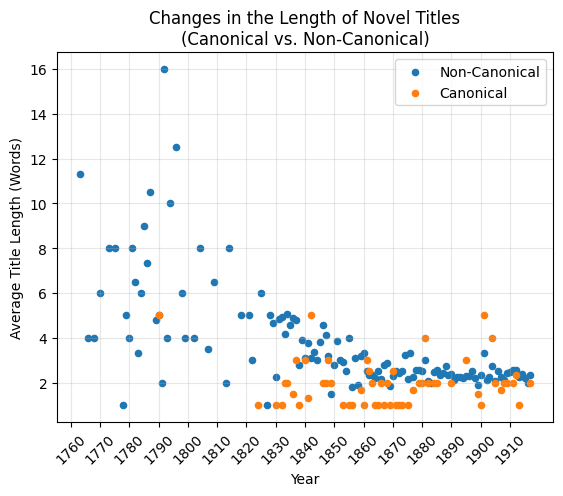

In [96]:
# title length: canonical vs non-canonical

grouped = df.groupby(['year_begin', 'canon_status'])['title_length'].mean().reset_index()

canonical = grouped[grouped['canon_status'] == 1]
non_canonical = grouped[grouped['canon_status'] == 0]

plt.scatter(non_canonical['year_begin'], non_canonical['title_length'], label='Non-Canonical', marker='o', color='tab:blue', s=20)
plt.scatter(canonical['year_begin'], canonical['title_length'], label='Canonical', marker='o', color='tab:orange', s=20)


plt.xlabel('Year')
plt.ylabel('Average Title Length (Words)')
plt.title('Changes in the Length of Novel Titles\n(Canonical vs. Non-Canonical)')
plt.xticks(range(1760, 1920, 10), rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/title_length_canonical_vs_noncanonical.png', dpi=150, bbox_inches='tight')

plt.show()


## SBERT Embeddings of Titles


### Embedding Generation

In [97]:
# tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
# model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# #Mean Pooling - Take attention mask into account for correct averaging
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
#     sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#     return sum_embeddings / sum_mask
    
# def get_embedding(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return mean_pooling(outputs, inputs['attention_mask']).squeeze().cpu().numpy()

# def create_document_embeddings(texts, batch_size=2029):
#     embeddings = []
#     if not isinstance(texts, list):
#         texts = texts.tolist()
#     for i in tqdm(range(0, len(texts), batch_size), desc="Creating embeddings"):
#         batch = texts[i:i + batch_size]
#         inputs = tokenizer(
#             batch,
#             padding=True,
#             truncation=True,
#             max_length=256,
#             return_tensors="pt"
#         ).to(device)

#         with torch.no_grad():
#             outputs = model(**inputs)
#             batch_embeddings = mean_pooling(outputs, inputs['attention_mask'])
#             embeddings.append(batch_embeddings.cpu().numpy())
    
#     return np.concatenate(embeddings, axis=0)

# titles = data['title'].tolist()

# document_embeddings = create_document_embeddings(titles)
# normalized_embeddings = normalize(document_embeddings)

# similarity_matrix = cosine_similarity(normalized_embeddings)
# similarity_df = pd.DataFrame(similarity_matrix, index=titles, columns=titles)

In [98]:
# title_to_embedding = dict(zip(data['title'], normalized_embeddings))
# with open('data/sberbank-ai-sbert_large_nlu_ru_mp.pickle', 'wb') as f:
#     pickle.dump(title_to_embedding, f)

# similarity_df.to_csv("data/sberbank-ai-sbert_large_nlu_ru_mp.csv")


### Loading Pre-computed Embeddings

In [99]:
with open('data/sberbank-ai-sbert_large_nlu_ru_mp.pickle', 'rb') as f:
    title_to_embedding = pickle.load(f)
similarity_df = pd.read_csv('data/sberbank-ai-sbert_large_nlu_ru_mp.csv', index_col=0)
similarity_df

,Эпизод из владычества Биронова,Тень века сего (Записки Абашева),Лилии,Мои времена в 30-х годах,Тамарин,Приличная партия,Подводный камень,Меж двух огней,В сороковых годах,Три венца,...,Лицемеры,Горный ручей,Нечистая сила,Юрьева могила,Нежеланные дети,1 марта 1881,Прекрасные уроды,Жар-птица,Под плащом Сатаны,Крепостники
Эпизод из владычества Биронова,1.000000,0.643677,0.337848,0.552581,0.547460,0.281048,0.471472,0.407704,0.445362,0.389027,...,0.336414,0.477167,0.527825,0.385258,0.439270,0.387805,0.391130,0.481756,0.446773,0.446708
Тень века сего (Записки Абашева),0.643677,1.000000,0.352795,0.479430,0.493027,0.220441,0.405734,0.421277,0.357366,0.340920,...,0.323519,0.446000,0.518557,0.431683,0.427563,0.476899,0.368291,0.464254,0.468664,0.476456
Лилии,0.337848,0.352795,1.000000,0.322685,0.597405,0.453922,0.588081,0.406095,0.273050,0.529465,...,0.437389,0.590848,0.452150,0.416440,0.486966,0.264706,0.502833,0.619994,0.437582,0.467013
Мои времена в 30-х годах,0.552581,0.479430,0.322685,1.000001,0.409913,0.325186,0.381994,0.428353,0.754097,0.432332,...,0.367599,0.464701,0.436421,0.439103,0.428991,0.457530,0.414993,0.394812,0.414087,0.438829
Тамарин,0.547460,0.493027,0.597405,0.409913,1.000000,0.404809,0.660774,0.497565,0.357666,0.581773,...,0.434176,0.664404,0.572355,0.489444,0.512496,0.344472,0.437366,0.660296,0.519348,0.516369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1 марта 1881,0.387805,0.476899,0.264706,0.457530,0.344472,0.194543,0.304539,0.321409,0.514700,0.395387,...,0.163587,0.296028,0.249578,0.287660,0.255412,1.000000,0.190073,0.298582,0.337996,0.305903
Прекрасные уроды,0.391130,0.368291,0.502833,0.414993,0.437366,0.571418,0.403927,0.316329,0.308929,0.380909,...,0.798910,0.491753,0.509968,0.417839,0.659969,0.190073,1.000000,0.407022,0.436907,0.592315
Жар-птица,0.481756,0.464254,0.619994,0.394812,0.660296,0.369718,0.636896,0.539747,0.318598,0.489314,...,0.400148,0.564190,0.670568,0.500219,0.483481,0.298582,0.407022,1.000001,0.566182,0.472699
Под плащом Сатаны,0.446773,0.468664,0.437582,0.414087,0.519348,0.321668,0.487059,0.636508,0.436239,0.534462,...,0.498238,0.549923,0.666256,0.554366,0.475517,0.337996,0.436907,0.566182,1.000000,0.470000


### Finding Top N Most Similar Titles to a Given Title

In [100]:
similarity_matrix = similarity_df.values

In [101]:
def get_top_similar(title, similarity_df, top_n=10):
    """find top N most similar titles to a given title"""
    if title not in similarity_df.index:
        print(f"Title '{title}' not found.")
        return pd.Series()
    similarities = similarity_df.loc[title]
    return similarities.drop(title).nlargest(top_n)

def create_similarity_pairs(similarity_df, threshold=0.4):
    """create pairs of titles with similarity above threshold"""
    pairs = []
    titles = similarity_df.index.tolist()
    for i in range(len(titles)):
        for j in range(i + 1, len(titles)):
            similarity = similarity_df.iloc[i, j]
            if similarity >= threshold:
                pairs.append({'title1': titles[i], 'title2': titles[j], 'similarity': similarity})
    return pd.DataFrame(pairs)

# create similarity pairs
similar_pairs_df = create_similarity_pairs(similarity_df)
filtered_pairs = similar_pairs_df[(similar_pairs_df['similarity'] < 1.0) & 
                                  (similar_pairs_df['title1'] != similar_pairs_df['title2'])]
sorted_similar_pairs = filtered_pairs.sort_values('similarity', ascending=False)
sorted_similar_pairs.head(50)

,title1,title2,similarity
58094,Восьмидесятники,Девятидесятники,0.991279
1045704,Во тьме,Во мраке,0.980981
158320,Из огня да в полымя,"Из огня, да в полымя",0.976156
859328,Петербургские трущобы,Московские трущобы,0.968052
1150100,Три счастья,Два счастья,0.967201
669946,Аскольдова могила,Юрьева могила,0.966149
958437,Княгиня Лиговская,Княгиня Бутырская,0.965672
1228821,Из недалекого прошлого,Из далекого прошлого,0.960529
712015,Коломенская роза,Иерихонская роза,0.959115
19122,Млечный путь,Тернистый путь,0.956038


In [102]:
top_similar = get_top_similar('История одного убийства', similarity_df)
print(top_similar)

История одного товарищества                     0.821004
История бледного молодого человека              0.791895
История одного города                           0.788815
История "розового негодяя"                      0.785676
Эпизод из жизни Тиверия                         0.780876
История одного преступления: (Власть сердца)    0.774991
История одного развода                          0.774538
История одной жизни                             0.764417
История одной молодости                         0.736187
Эпизод из владычества Биронова                  0.730933
Name: История одного убийства, dtype: float64


In [103]:
top_similar = get_top_similar('Женщина-демон', similarity_df)
print(top_similar)

Женщина-изверг                                            0.881416
Черная женщина                                            0.838955
Ведьма                                                    0.830267
Дочь дьявола                                              0.828548
Демон наготы                                              0.807087
Человек, женщина и демон                                  0.803084
Одна из женщин XIX века                                   0.800553
Женщина XIX столетия                                      0.792228
Спиритка-убийца                                           0.778605
Защитница женщин Ленора, гроза вероломных развратников    0.776842
Name: Женщина-демон, dtype: float64


In [104]:
top_similar = get_top_similar('Женщина XIX столетия', similarity_df)
print(top_similar)

Одна из женщин XIX века                     0.928201
Женщина-демон                               0.792228
Женщина - поэт и автор                      0.760377
Черная женщина                              0.748802
Бароцейская королева                        0.739350
Женщина-изверг                              0.738973
Первая русская царица                       0.733050
Женщины из большого петербургского света    0.730920
Женщина в купеческом быту                   0.727988
Дочь Великого Петра                         0.726014
Name: Женщина XIX столетия, dtype: float64


In [105]:
top_similar = get_top_similar('Отцы и дети', similarity_df)
print(top_similar)

Мать и дочь        0.855046
Мужья и жёны       0.841537
Дед и внук         0.814527
Дети               0.808675
Брат и сестра      0.769439
Брат и сестра.1    0.769439
Близнецы           0.738789
Наследники         0.738417
Дети земли         0.722577
Семья Колениных    0.717568
Name: Отцы и дети, dtype: float64


In [106]:
top_similar = get_top_similar('Рудин', similarity_df)
print(top_similar)

Санин        0.933182
Лорин        0.885642
Нерон        0.879328
Кудеяр       0.878254
Дубровин     0.870797
Тамарин      0.869943
Гайдамак     0.851797
Рославлев    0.849581
Рингильда    0.847934
Ирод         0.847546
Name: Рудин, dtype: float64


In [107]:
top_similar = get_top_similar('Бедные люди', similarity_df)
print(top_similar)

Бедные дворяне      0.816216
Счастливые люди     0.801199
Прекрасные уроды    0.765754
Честные люди        0.760242
Праздные люди       0.759230
Лицемеры            0.746297
Скорбящие           0.743063
Озлобленные         0.740866
Зачумленные         0.729356
Захудалые           0.724293
Name: Бедные люди, dtype: float64


In [108]:
top_similar = get_top_similar('Прекрасные уроды', similarity_df)
print(top_similar)

Лицемеры                    0.798910
Честные люди                0.790022
Зачумленные                 0.785500
Герои и предатели           0.778827
Одержимые                   0.769523
Бедные люди                 0.765754
Равнодушные                 0.765062
Озлобленные                 0.764246
Униженные и оскорбленные    0.754600
Невменяемые                 0.749593
Name: Прекрасные уроды, dtype: float64


In [109]:
top_similar = get_top_similar('Лицемеры', similarity_df)
print(top_similar)

Греховодники                0.829480
Крамольники                 0.822914
Герои и предатели           0.820276
Одержимые                   0.809121
Прекрасные уроды            0.798910
Озлобленные                 0.797050
Зачумленные                 0.794636
Отверженный                 0.789757
Неоконсерваторы             0.785188
Униженные и оскорбленные    0.782741
Name: Лицемеры, dtype: float64


In [110]:
top_similar = get_top_similar('Жизнь и похождения Тихона Тростникова', similarity_df)
print(top_similar)

Жизнь и похождения Петра Степанова сына Столбикова, помещика в трех наместничествах    0.795098
Изумительные похождения московского Пинкертона Агафона и его слуги Луки                0.791550
Тонкий человек, его приключения и наблюдения                                           0.757315
Приключения петербургского Макарки Душегуба                                            0.753870
Награждённая постоянность, или Приключения Лизарка и Сарманды                          0.751264
Жизнь и приключения домашнего учителя                                                  0.744138
Российский Жилблаз, или Похождения графа Гаврилы Семеновича Чистякова                  0.744003
Странствия и приключения Никодима Старшего                                             0.742719
Любовные похождения мадам Вербицкой                                                    0.740757
Приключения царевича Густава Ириковича, жениха царевны Ксении Годуновой                0.733406
Name: Жизнь и похождения Тихона Тростник

In [111]:
top_similar = get_top_similar('История одной жизни', similarity_df)
print(top_similar)

История одной молодости               0.866168
История одного товарищества           0.800810
Барышни: Простая история жизни        0.789508
История одного города                 0.775840
История одного убийства               0.764417
История одного развода                0.763787
Обыкновенная история                  0.763536
Наши дни. Семейная история            0.758989
Эпизод из жизни Тиверия               0.755311
История бледного молодого человека    0.746042
Name: История одной жизни, dtype: float64


In [112]:
top_similar = get_top_similar('Женщина на пути', similarity_df)
print(top_similar)

Женщина-демон           0.746019
Черная женщина          0.721921
Женщина-изверг          0.721130
Проснулась женщина!     0.714763
Падчерица               0.686690
Баба                    0.682814
Женщина XIX столетия    0.676881
Сердце женщины          0.672372
Убийца                  0.672016
Три женщины             0.672001
Name: Женщина на пути, dtype: float64


In [113]:
top_similar = get_top_similar('Женщина XIX столетия', similarity_df)
print(top_similar)

Одна из женщин XIX века                     0.928201
Женщина-демон                               0.792228
Женщина - поэт и автор                      0.760377
Черная женщина                              0.748802
Бароцейская королева                        0.739350
Женщина-изверг                              0.738973
Первая русская царица                       0.733050
Женщины из большого петербургского света    0.730920
Женщина в купеческом быту                   0.727988
Дочь Великого Петра                         0.726014
Name: Женщина XIX столетия, dtype: float64


In [114]:
top_similar = get_top_similar('Отцы и дети', similarity_df)
print(top_similar)

Мать и дочь        0.855046
Мужья и жёны       0.841537
Дед и внук         0.814527
Дети               0.808675
Брат и сестра      0.769439
Брат и сестра.1    0.769439
Близнецы           0.738789
Наследники         0.738417
Дети земли         0.722577
Семья Колениных    0.717568
Name: Отцы и дети, dtype: float64


In [115]:
top_similar = get_top_similar('Рудин', similarity_df)
print(top_similar)

Санин        0.933182
Лорин        0.885642
Нерон        0.879328
Кудеяр       0.878254
Дубровин     0.870797
Тамарин      0.869943
Гайдамак     0.851797
Рославлев    0.849581
Рингильда    0.847934
Ирод         0.847546
Name: Рудин, dtype: float64


In [116]:
top_similar = get_top_similar('Бедные люди', similarity_df)
print(top_similar)

Бедные дворяне      0.816216
Счастливые люди     0.801199
Прекрасные уроды    0.765754
Честные люди        0.760242
Праздные люди       0.759230
Лицемеры            0.746297
Скорбящие           0.743063
Озлобленные         0.740866
Зачумленные         0.729356
Захудалые           0.724293
Name: Бедные люди, dtype: float64


In [117]:
top_similar = get_top_similar('Лицемеры', similarity_df)
print(top_similar)

Греховодники                0.829480
Крамольники                 0.822914
Герои и предатели           0.820276
Одержимые                   0.809121
Прекрасные уроды            0.798910
Озлобленные                 0.797050
Зачумленные                 0.794636
Отверженный                 0.789757
Неоконсерваторы             0.785188
Униженные и оскорбленные    0.782741
Name: Лицемеры, dtype: float64


In [118]:
top_similar = get_top_similar('Война и мир', similarity_df)
print(top_similar)

Любовь и корона                            0.820568
Месть и золото                             0.816592
Золото и кровь                             0.784745
Мрак и свет                                0.762810
Страсть и мщение                           0.755578
Пламир и Раида                             0.742454
Любовь и деньги                            0.740172
Любовь и вера, или Победа над страстями    0.737213
Мечты и жизнь                              0.728174
Лавры и тернии                             0.727993
Name: Война и мир, dtype: float64


In [119]:
top_similar = get_top_similar('Обыкновенная история', similarity_df)
print(top_similar)

Старая история                    0.797080
Женская история                   0.782873
История одной молодости           0.779379
Странная история                  0.766885
История одной жизни               0.763536
Небылица                          0.724588
Наши дни. Семейная история        0.714683
Игра судьбы                       0.699218
Барышни: Простая история жизни    0.696107
Развязка                          0.677241
Name: Обыкновенная история, dtype: float64


In [120]:
top_similar = get_top_similar('Развязка', similarity_df)
print(top_similar)

Финал                0.813084
Мертвая петля        0.762888
Мертвая петля.1      0.762888
Пролог               0.757837
Современная драма    0.742681
Игра судьбы          0.730570
Кровавая месть       0.722765
Месть дивы           0.713951
Кровавая слава       0.712219
Драма за сценой      0.708254
Name: Развязка, dtype: float64


In [121]:
top_similar = get_top_similar('Игра судьбы', similarity_df)
print(top_similar)

Воля судьбы      0.838908
Перст судьбы     0.831638
Судьба           0.771082
Игра             0.747184
Жертва случая    0.742369
Тайна жизни      0.738206
Приманка         0.736504
Лотерея          0.735918
Развязка         0.730570
Грядущая сила    0.723693
Name: Игра судьбы, dtype: float64


In [122]:
top_similar = get_top_similar('Тайна жизни', similarity_df)
print(top_similar)

Тайна любви         0.898039
Тайна радости       0.852542
Тайны сердца        0.813763
Порча жизни         0.809983
Побеги жизни        0.782559
Грядущая сила       0.771271
Радость жизни       0.767704
Тайные силы         0.765196
Заря жизни          0.762922
Творимая легенда    0.758858
Name: Тайна жизни, dtype: float64


### Cosine Similarity Matrix of Titles by Decade

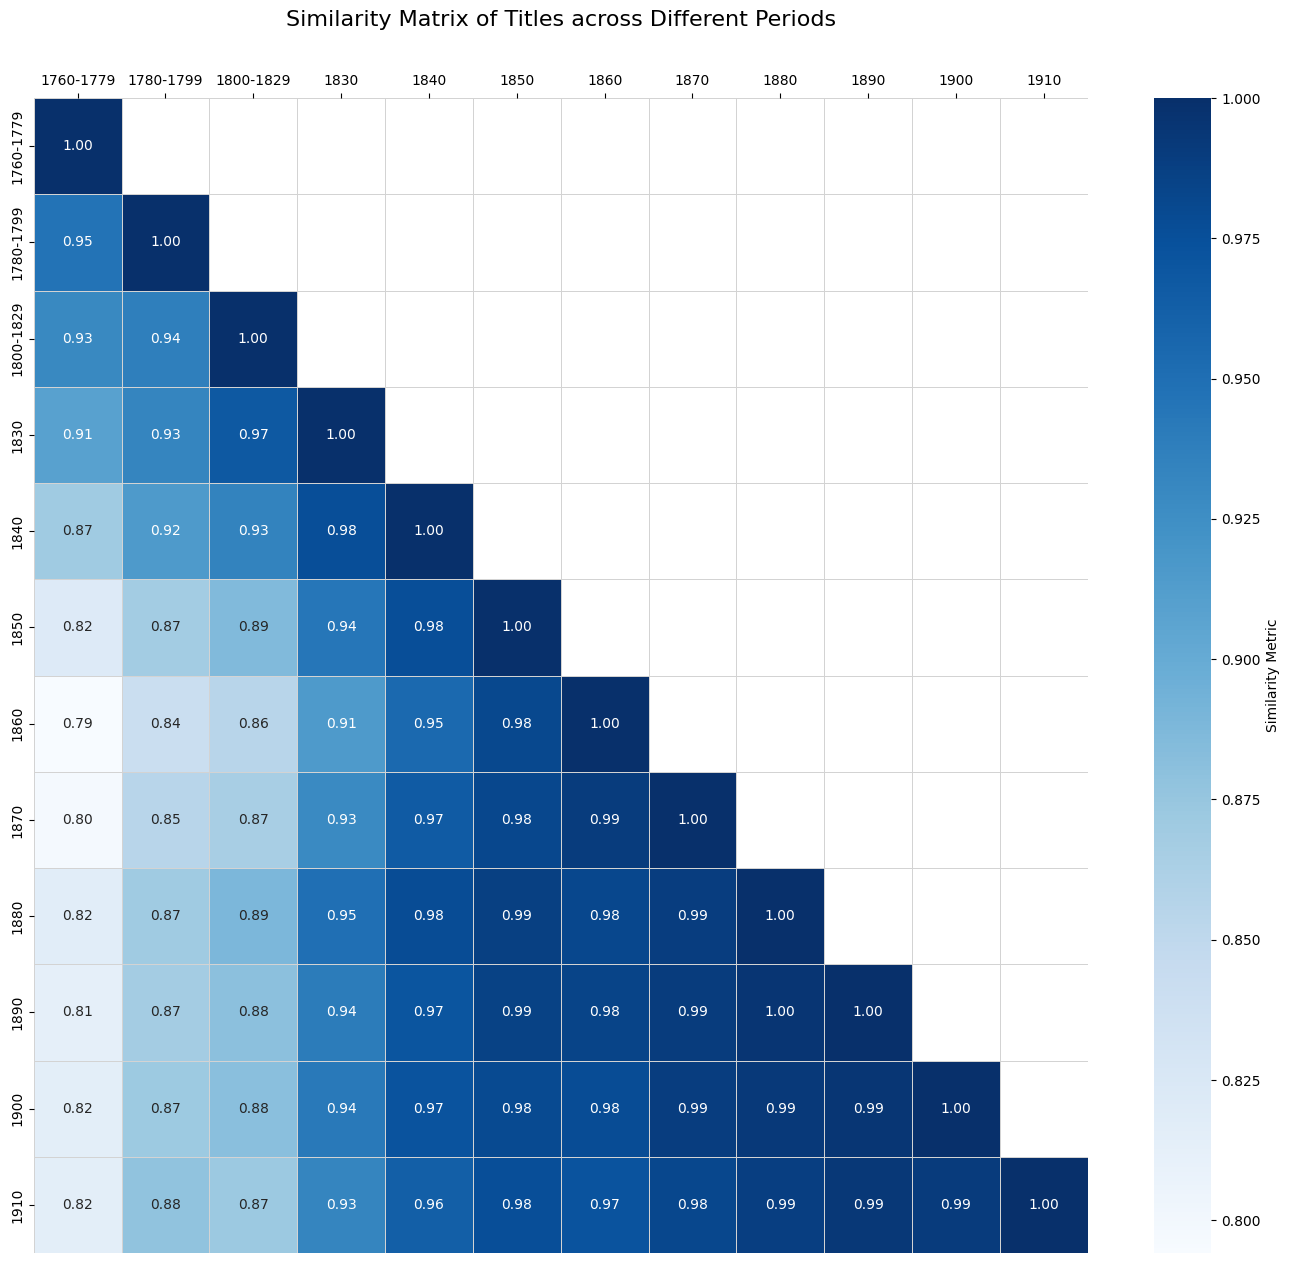

In [123]:
# group titles by period
period_titles = {'1760-1779': [], '1780-1799': [], '1800-1829': []}

for title, year in zip(data['title'], data['year_begin']):
    if 1760 <= year <= 1779:
        period = '1760-1779'
    elif 1780 <= year <= 1799:
        period = '1780-1799'
    elif 1800 <= year <= 1829:
        period = '1800-1829'
    else:
        period = (year // 10) * 10
    if period not in period_titles:
        period_titles[period] = []
    period_titles[period].append(title)

# compute average embedding for each period
period_embeddings = {}
for period, titles in period_titles.items():
    embeddings = [title_to_embedding[title] for title in titles if title in title_to_embedding]
    if embeddings:
        period_embeddings[period] = np.mean(embeddings, axis=0)

periods = sorted(period_embeddings.keys(), 
                key=lambda x: int(x.split('-')[0]) if isinstance(x, str) and '-' in x else x)

# compute period similarity matrix
period_similarity_matrix = np.zeros((len(periods), len(periods)))
for i, period1 in enumerate(periods):
    for j, period2 in enumerate(periods):
        period_similarity_matrix[i, j] = cosine_similarity([period_embeddings[period1]], 
                                                           [period_embeddings[period2]])[0, 0]

# plot heatmap
mask = np.triu(np.ones_like(period_similarity_matrix, dtype=bool), k=1)
plt.figure(figsize=(17, 15))
ax = sns.heatmap(period_similarity_matrix, xticklabels=periods, yticklabels=periods,
                 cmap='Blues', annot=True, fmt=".2f", mask=mask,
                 cbar_kws={'label': 'Similarity Metric'},
                 linewidths=.5, linecolor='lightgray')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.title('Similarity Matrix of Titles across Different Periods', fontsize=16, pad=20)
plt.xlabel(' ', fontsize=14)
plt.savefig('figures/similarity_matrix_by_decade.png', dpi=150, bbox_inches='tight')
plt.show()

### Trajectories of Influence of Titles from Each Decade


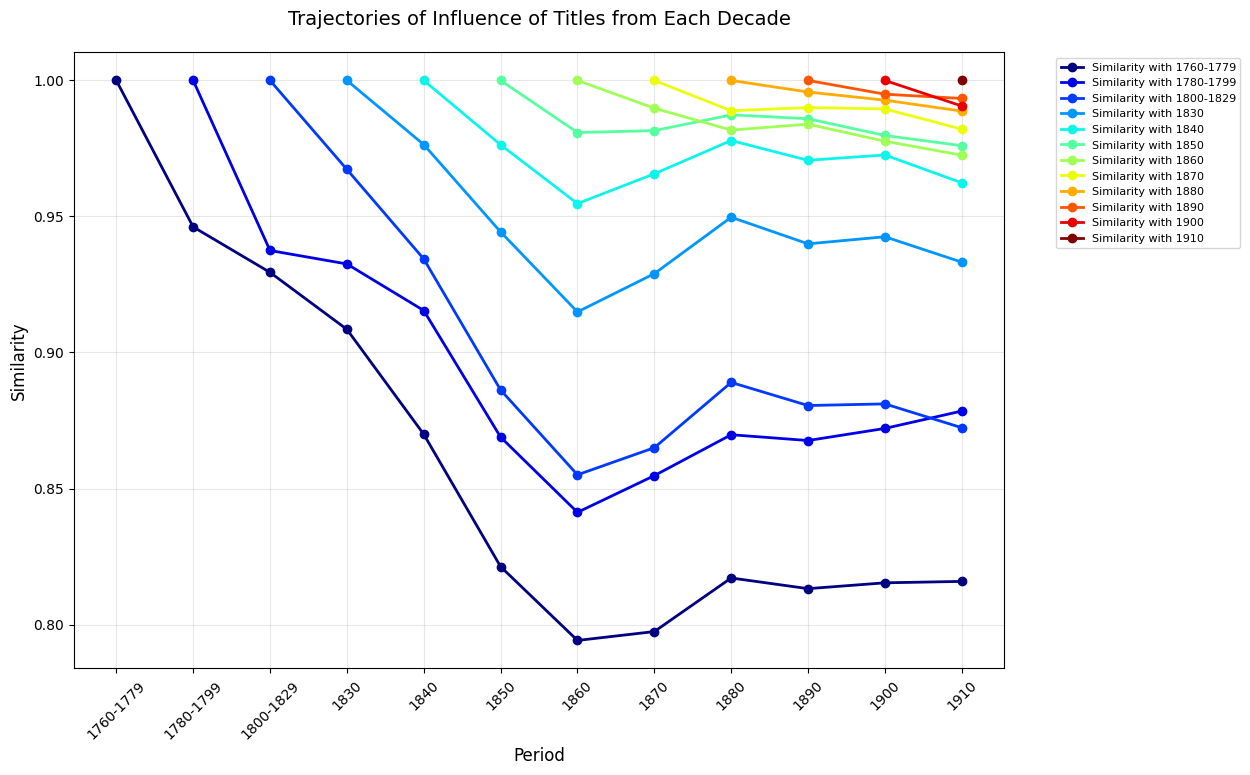

In [124]:
periods_str = [str(p) for p in periods]
plt.figure(figsize=(12, 8))
colors = plt.cm.jet(np.linspace(0, 1, len(periods)))

for i, base_period in enumerate(periods):
    similarity_values = period_similarity_matrix[i, i:]
    x_labels = periods_str[i:]
    label = f"Similarity with {base_period}"
    plt.plot(x_labels, similarity_values, marker='o', color=colors[i], 
             label=label, linewidth=2)

plt.xlabel("Period", fontsize=12)
plt.ylabel("Similarity", fontsize=12)
plt.title("Trajectories of Influence of Titles from Each Decade", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.savefig('figures/influence_trajectories.png', dpi=150, bbox_inches='tight')
plt.show()

### Dynamics of Similarity from Period to Period


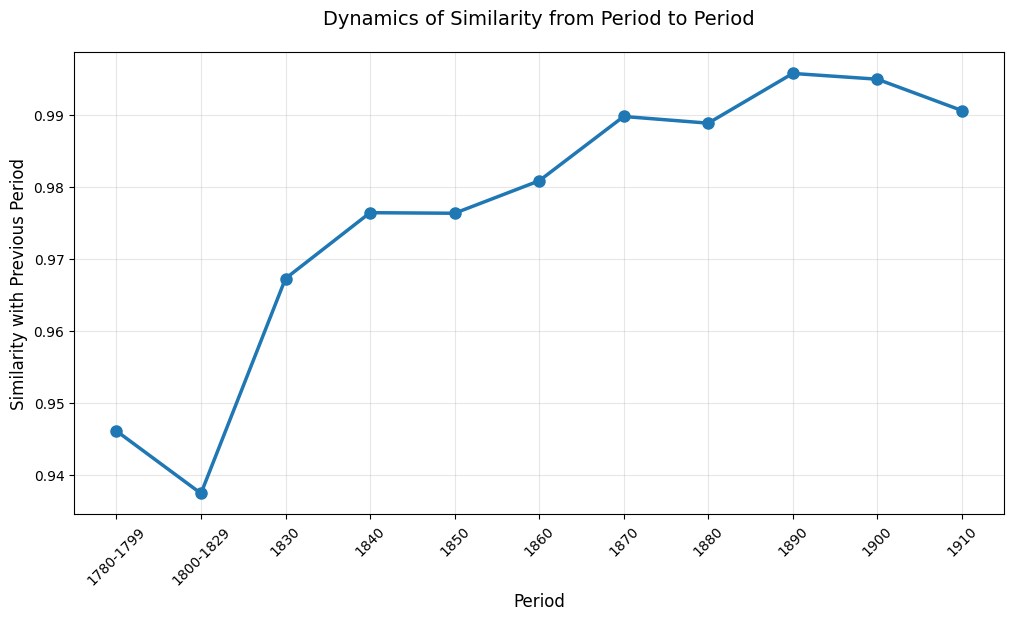

In [125]:
similarity_values = np.diag(period_similarity_matrix, k=-1)
x_labels_dynamics = periods_str[1:]

plt.figure(figsize=(12, 6))
plt.plot(x_labels_dynamics, similarity_values, marker='o', linestyle='-', 
         linewidth=2.5, markersize=8)
plt.xlabel("Period", fontsize=12)
plt.ylabel("Similarity with Previous Period", fontsize=12)
plt.title("Dynamics of Similarity from Period to Period", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.savefig('figures/similarity_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

### Distribution of Title Novelty

In [126]:
def compute_novelty(title_to_embedding, data):
    """compute novelty as cosine distance from average of all preceding titles"""
    novelty_scores = []
    averaged_embedding = np.zeros(len(next(iter(title_to_embedding.values()))))
    embedding_count = 0

    for _, row in data.iterrows():
        current_title = row['title']
        current_embedding = title_to_embedding[current_title]
        
        if embedding_count > 0:
            novelty_score = cosine(current_embedding, averaged_embedding)
        else:
            novelty_score = np.nan
        
        novelty_scores.append(novelty_score)
        
        # update averaged embedding
        averaged_embedding = (averaged_embedding * embedding_count + current_embedding) / (embedding_count + 1)
        embedding_count += 1
    
    return novelty_scores

# compute novelty for all titles
data['novelty'] = compute_novelty(title_to_embedding, data)

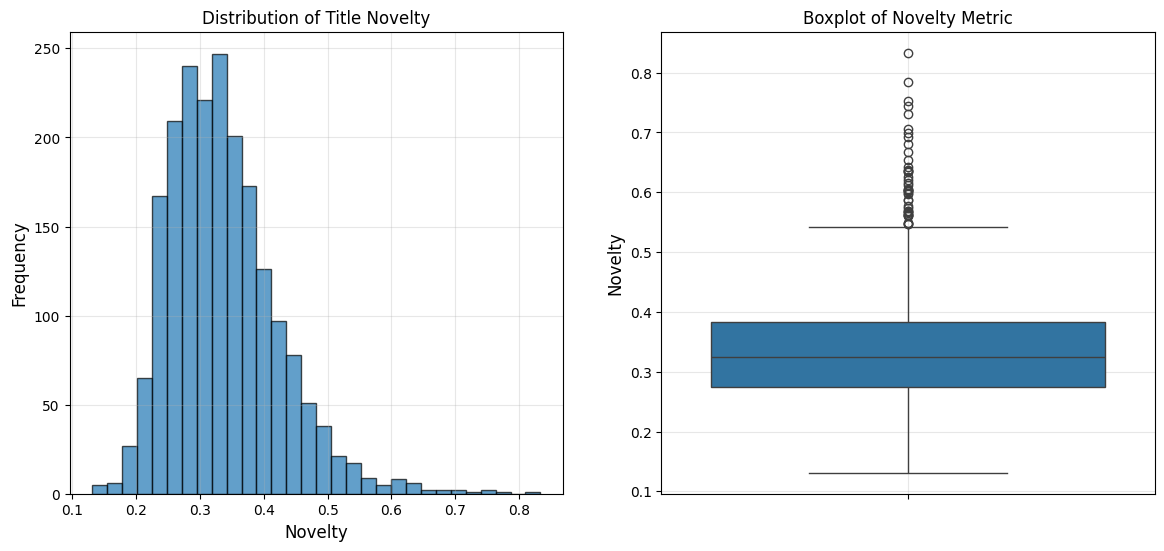

In [127]:
# distribution of novelty
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(data['novelty'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Novelty', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Title Novelty', fontsize=12)
axes[0].grid(True, alpha=0.3)

sns.boxplot(y=data['novelty'], ax=axes[1])
axes[1].set_title('Boxplot of Novelty Metric', fontsize=12)
axes[1].set_ylabel('Novelty', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.savefig('figures/novelty_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### Top Titles Most Dissimilar to Previous Titles


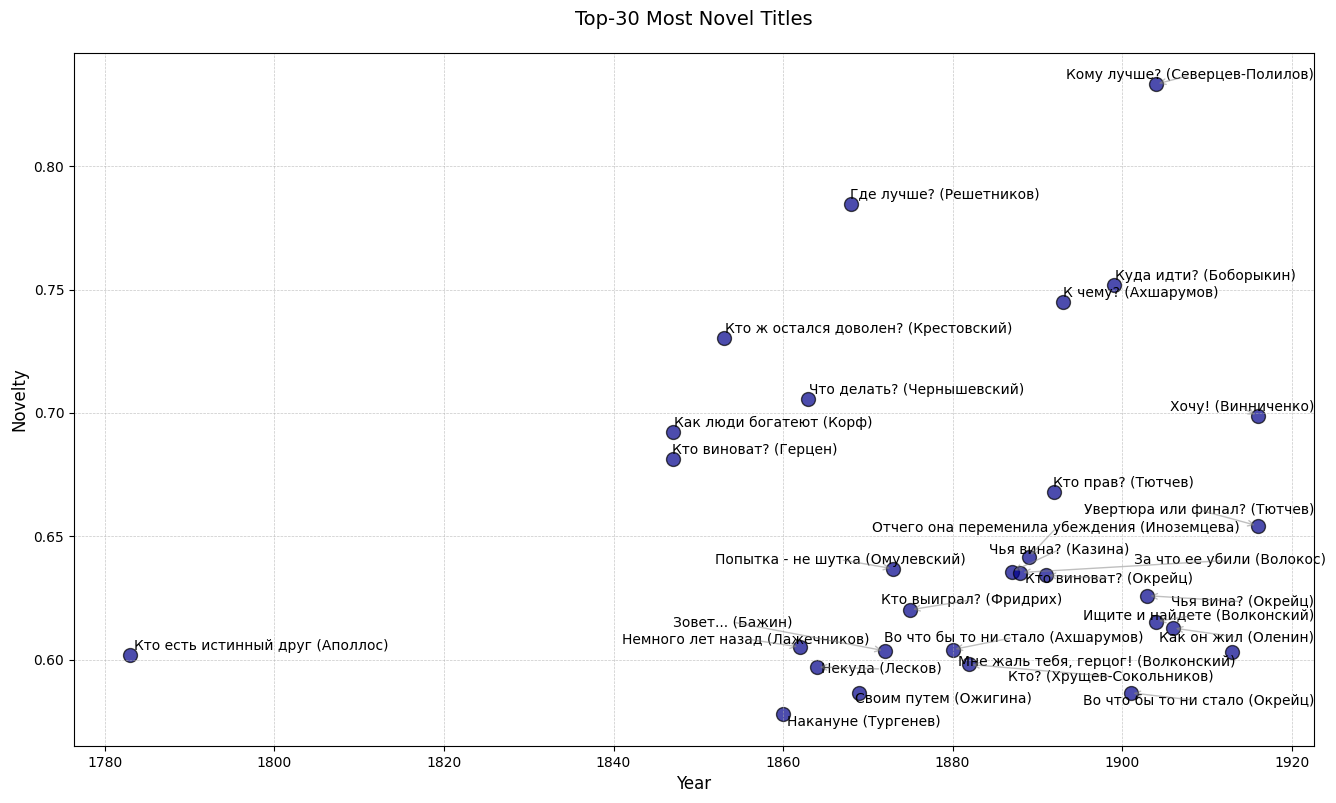

In [128]:
df_top30 = data.sort_values('novelty', ascending=False).head(30)

plt.figure(figsize=(16, 9), dpi=100)
plt.scatter(df_top30['year_begin'], df_top30['novelty'],
            color='darkblue', alpha=0.7, s=100, 
            edgecolors='black', linewidth=1)

# add labels
texts = []
for i, row in df_top30.iterrows():
    author_last_name = row['author'].split(',')[0]
    label = f"{row['title']} ({author_last_name})"
    texts.append(plt.text(row['year_begin'], row['novelty'], label))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
            expand_points=(1.2, 1.2))

plt.xlabel('Year', fontsize=12)
plt.ylabel('Novelty', fontsize=12)
plt.title('Top-30 Most Novel Titles', fontsize=14, pad=20)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig('figures/top_novel_titles.png', dpi=100, bbox_inches='tight')
plt.show()

### Distribution of Novelty: Canonical vs. Non-Canonical Novels


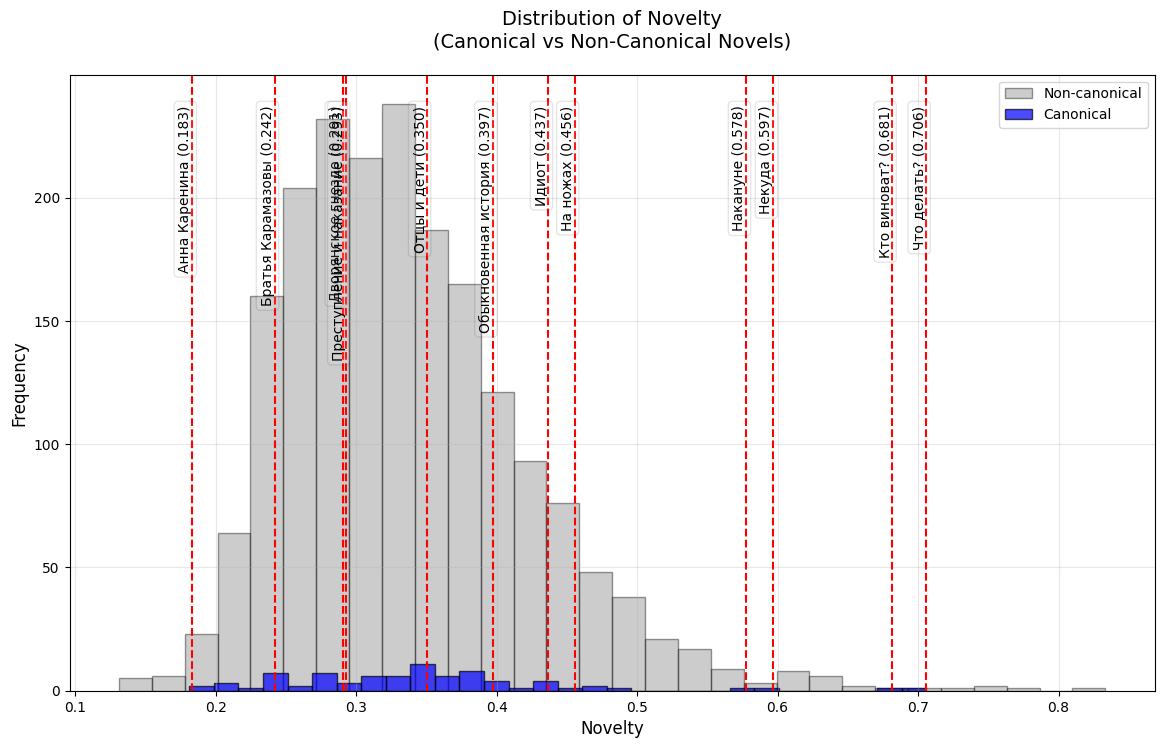

In [129]:
# highlighted canonical titles
highlight_titles = [
    "Кто виноват?", "Что делать?", "Некуда", "Накануне",
    "Отцы и дети", "Преступление и наказание", "Братья Карамазовы",
    "Анна Каренина", "Дворянское гнездо", "Обыкновенная история",
    "На ножах", "Идиот"
]

data_non_canon = data[data['canon_status'] == 0]
data_canon = data[data['canon_status'] == 1]
highlighted_novels = data_canon[data_canon['title'].isin(highlight_titles)]

fig, ax = plt.subplots(figsize=(14, 8))

# histograms
ax.hist(data_non_canon['novelty'], bins=30, edgecolor='black', alpha=0.4, 
        label='Non-canonical', color='gray')
ax.hist(data_canon['novelty'], bins=30, edgecolor='black', alpha=0.7, 
        label='Canonical', color='blue')

# highlight selected canonical novels
for _, row in highlighted_novels.iterrows():
    ax.axvline(x=row['novelty'], color='red', linestyle='dashed', linewidth=1.5)
    ax.text(row['novelty'], ax.get_ylim()[1] * 0.95, 
            f"{row['title']} ({row['novelty']:.3f})",
            rotation=90, verticalalignment='top', horizontalalignment='right',
            fontsize=10, bbox=dict(boxstyle="round", alpha=0.1, facecolor='white'))

ax.set_xlabel('Novelty', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Novelty\n(Canonical vs Non-Canonical Novels)', fontsize=14, pad=20)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.savefig('figures/novelty_canonical_highlighted.png', dpi=150, bbox_inches='tight')
plt.show()

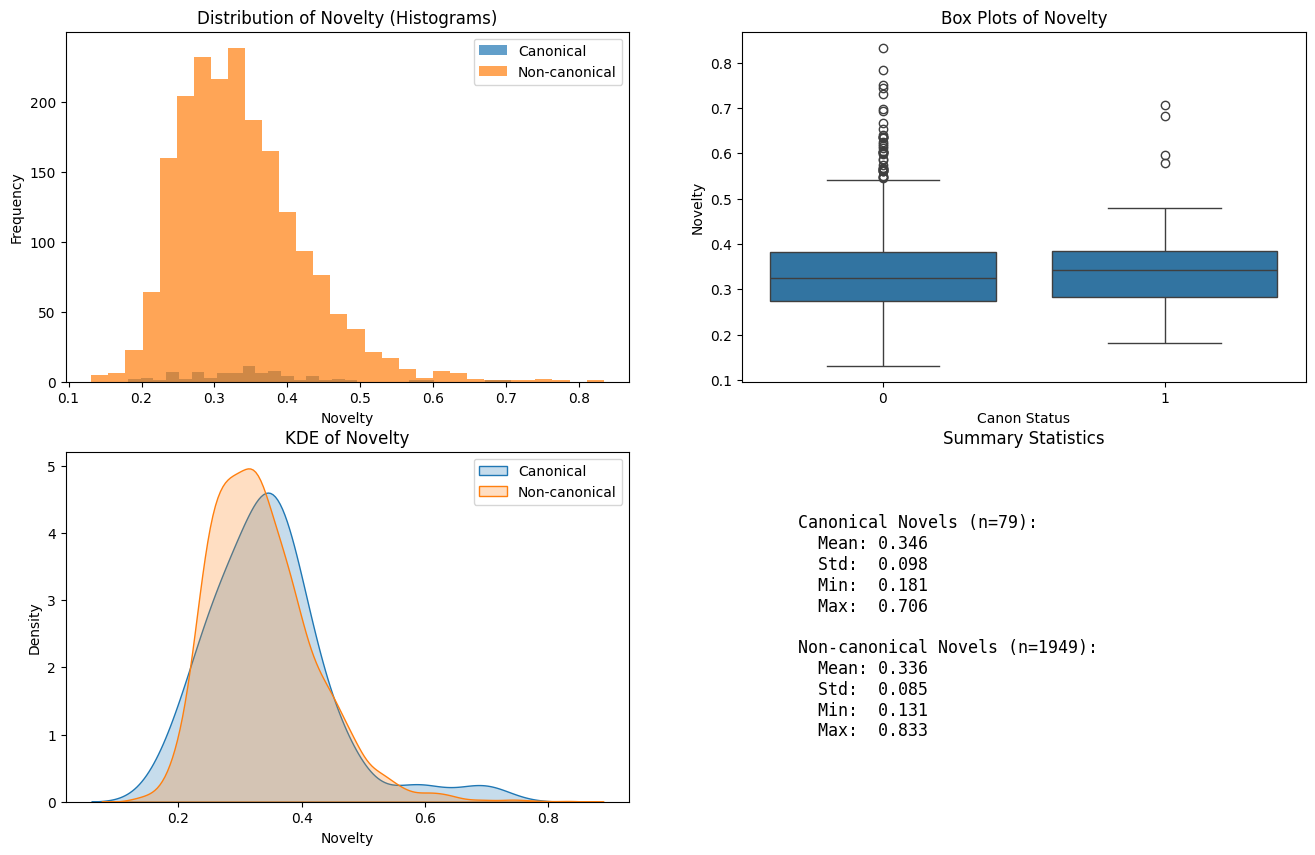

In [130]:
# detailed comparison: canonical vs non-canonical
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# histograms
axes[0, 0].hist(data[data['canon_status'] == 1]['novelty'], bins=30, alpha=0.7, label='Canonical')
axes[0, 0].hist(data[data['canon_status'] == 0]['novelty'], bins=30, alpha=0.7, label='Non-canonical')
axes[0, 0].set_xlabel('Novelty')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Novelty (Histograms)')
axes[0, 0].legend()

# box plots
sns.boxplot(x='canon_status', y='novelty', data=data, ax=axes[0, 1])
axes[0, 1].set_xlabel('Canon Status')
axes[0, 1].set_ylabel('Novelty')
axes[0, 1].set_title('Box Plots of Novelty')

# KDE
sns.kdeplot(data[data['canon_status'] == 1]['novelty'], fill=True, label='Canonical', ax=axes[1, 0])
sns.kdeplot(data[data['canon_status'] == 0]['novelty'], fill=True, label='Non-canonical', ax=axes[1, 0])
axes[1, 0].set_xlabel('Novelty')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('KDE of Novelty')
axes[1, 0].legend()

# statistics
axes[1, 1].axis('off')
canon_stats = data[data['canon_status'] == 1]['novelty'].describe()
non_canon_stats = data[data['canon_status'] == 0]['novelty'].describe()
stats_text = f"""
Canonical Novels (n={int(canon_stats['count'])}):
  Mean: {canon_stats['mean']:.3f}
  Std:  {canon_stats['std']:.3f}
  Min:  {canon_stats['min']:.3f}
  Max:  {canon_stats['max']:.3f}

Non-canonical Novels (n={int(non_canon_stats['count'])}):
  Mean: {non_canon_stats['mean']:.3f}
  Std:  {non_canon_stats['std']:.3f}
  Min:  {non_canon_stats['min']:.3f}
  Max:  {non_canon_stats['max']:.3f}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, family='monospace', verticalalignment='center')
axes[1, 1].set_title('Summary Statistics')

plt.savefig('figures/novelty_canonical_vs_noncanonical_detailed.png', dpi=150, bbox_inches='tight')
plt.show()

In [131]:
stats_text

'\nCanonical Novels (n=79):\n  Mean: 0.346\n  Std:  0.098\n  Min:  0.181\n  Max:  0.706\n\nNon-canonical Novels (n=1949):\n  Mean: 0.336\n  Std:  0.085\n  Min:  0.131\n  Max:  0.833\n'

In [132]:
# canonical novels with high novelty
high_novelty = data[(data['canon_status'] == 1) & (data['novelty'] > 0.5)]
print(f"Canonical novels with novelty > 0.5: {len(high_novelty)}")
high_novelty[['author', 'title', 'novelty']].sort_values('novelty', ascending=False)

Canonical novels with novelty > 0.5: 4


,author,title,novelty
469,"Чернышевский, Николай Гаврилович",Что делать?,0.705750
312,"Герцен, Александр Иванович",Кто виноват?,0.681470
473,"Лесков, Николай Семенович",Некуда,0.597004
426,"Тургенев, Иван Сергеевич",Накануне,0.577844
